# Packages loading

In [1]:
import pickle
import sys
import os
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import re

from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pwd

# Data loading

<span style="font-size:18px;">The dataset is downloaded from **[Wen et al., 2020, Nat Neurosci](https://www.nature.com/articles/s41593-020-0586-x)**, we did the upstream pre-processing, and use the subset of Astrocyte and Microglia as the example for model training</span>

In [58]:
adata = sc.read_h5ad("./Dataset_for_training/Wen_et_al_2020.h5ad")

/lustre/fs4/cao_lab/store/lzhong01/miniconda3/envs/pytorch/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [59]:
adata

AnnData object with n_obs × n_vars = 81736 × 55416
    obs: 'cell_type', 'Age_Time', 'total_UMI', 'TOD'
    var: 'gene_id', 'gene_type', 'gene_name'

In [60]:
adata.obs

,cell_type,Age_Time,total_UMI,TOD
0,Neurons,Adult_18,18239.0,18.0
1,Neurons,Adult_54,10426.0,6.0
2,Neurons,Aged_26,14542.0,2.0
3,Neurons,Adult_38,11344.0,14.0
4,Neurons,Adult_38,11368.0,14.0
...,...,...,...,...
81731,Microglia,Aged_50,11424.0,2.0
81732,Microglia,Aged_50,10343.0,2.0
81733,Microglia,Aged_50,10526.0,2.0
81734,Microglia,Aged_50,10206.0,2.0


In [61]:
Microglia_adata = adata[adata.obs['cell_type'] == 'Microglia']

In [129]:
Astrocyte_adata = adata[adata.obs['cell_type'] == 'Astrocyte']

# ANN define

In [7]:
# Define dataset: expression matrix + times
class CircadianDataset(Dataset):
    def __init__(self, expr_matrix, times):
        """
        expr_matrix: numpy array of shape (N_cells, N_genes)
        times: numpy array of shape (N_cells,), use "hours" as unit, range: [0,24)
        """
        # Original expression matrix (float32), each row represents a cell and each column represents a gene
        self.X = expr_matrix.astype(np.float32)

        # Map the time from [0,24) to the Angle [0,2 π) on the circle and calculate sin/cos as the model label
        # This avoids the breakpoint problem of 23h ↔ 1h
        radians = times / 24.0 * 2 * np.pi
        self.y = np.stack([np.sin(radians), np.cos(radians)], axis=1).astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return (expression_vector, [sin(time), cos(time)])
        return self.X[idx], self.y[idx]

In [8]:
class CircadianNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout=0.2):
        super().__init__()
        layers = []

        # Feedforward Hidden Layer Design:
            # - First layer: Mapping from input_dim (number of genes) to 256 neurons
            # - Second Layer: 256 → 128
        # After each layer, ReLU activation is connected to enhance the nonlinear expression capability
        # And use Dropout(0.2) to prevent overfitting
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))  # Fully connected layer
            layers.append(nn.ReLU())               # Activation function
            layers.append(nn.Dropout(dropout))     # Random inactivation of 20%
            prev_dim = h

        # Output layer: Two neurons, corresponding respectively to sin(time) and cos(time)
        layers.append(nn.Linear(prev_dim, 2))

        # Combine all layers in sequence
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
    # Return mean loss
    return total_loss / len(dataloader.dataset)

In [10]:
def circular_mae(pred, true):
    """
    Calculate the Circular mean absolute error (Circular MAE) and the predicted sin/cos vector
    After converting to an Angle, calculate the minimum radian difference from the true Angle and then convert it to hours.
    """
    # atan2 param：sin, cos
    ang_pred = torch.atan2(pred[:,0], pred[:,1])
    ang_true = torch.atan2(true[:,0], true[:,1])
    # Normalize errors to [-π, π]
    diff = torch.remainder(ang_pred - ang_true + np.pi, 2*np.pi) - np.pi
    # Convert the radians to hours，24h correspondes to 2π
    return torch.mean(torch.abs(diff)) * (24/(2*np.pi))

In [26]:
def evaluate(model, dataloader, device):
    model.eval()
    total_mae = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            out = model(X_batch)
            total_mae += circular_mae(out, y_batch).item() * X_batch.size(0)
    return total_mae / len(dataloader.dataset)

# ANN training

## Microglia

### Training & Validation

In [75]:
Microglia_adata

View of AnnData object with n_obs × n_vars = 9115 × 55416
    obs: 'cell_type', 'Age_Time', 'total_UMI', 'TOD'
    var: 'gene_id', 'gene_type', 'gene_name'

In [64]:
Microglia_adata.obs

,cell_type,Age_Time,total_UMI,TOD
72621,Microglia,Adult_54,10951.0,6.0
72622,Microglia,Adult_54,11212.0,6.0
72623,Microglia,Adult_54,11503.0,6.0
72624,Microglia,Adult_54,10004.0,6.0
72625,Microglia,Adult_54,10687.0,6.0
...,...,...,...,...
81731,Microglia,Aged_50,11424.0,2.0
81732,Microglia,Aged_50,10343.0,2.0
81733,Microglia,Aged_50,10526.0,2.0
81734,Microglia,Aged_50,10206.0,2.0


In [76]:
sampled_indices = Microglia_adata.obs.sample(frac=0.6, random_state=42).index
sampled_indices

Index(['74236', '80548', '78590', '80718', '78746', '80408', '74428', '81400',
       '76913', '77182',
       ...
       '74231', '80024', '78437', '77298', '77580', '80586', '77382', '74815',
       '79205', '77734'],
      dtype='object', length=5469)

In [77]:
Microglia_adata_training = Microglia_adata[sampled_indices, :].copy()

In [78]:
Microglia_adata_training

AnnData object with n_obs × n_vars = 5469 × 55416
    obs: 'cell_type', 'Age_Time', 'total_UMI', 'TOD'
    var: 'gene_id', 'gene_type', 'gene_name'

In [79]:
Microglia_adata_training.obs

,cell_type,Age_Time,total_UMI,TOD
74236,Microglia,Adult_50,10122.0,2.0
80548,Microglia,Aged_62,10118.0,14.0
78590,Microglia,Aged_30,10479.0,6.0
80718,Microglia,Aged_62,10246.0,14.0
78746,Microglia,Aged_30,10353.0,6.0
...,...,...,...,...
80586,Microglia,Aged_62,10136.0,14.0
77382,Microglia,Adult_62,10431.0,14.0
74815,Microglia,Adult_34,10758.0,10.0
79205,Microglia,Aged_22,10288.0,22.0


In [176]:
expr_matrix = Microglia_adata_training.X.toarray()

In [177]:
expr_matrix

array([[0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 5.],
       [0., 0., 3., ..., 0., 0., 2.],
       ...,
       [0., 0., 1., ..., 0., 0., 9.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 1., ..., 0., 0., 3.]], shape=(5469, 55416), dtype=float32)

In [178]:
N_cells, N_genes = expr_matrix.shape

In [179]:
times = Microglia_adata_training.obs['TOD']

In [180]:
times

74236     2.0
80548    14.0
78590     6.0
80718    14.0
78746     6.0
         ... 
80586    14.0
77382    14.0
74815    10.0
79205    22.0
77734    10.0
Name: TOD, Length: 5469, dtype: float64

In [181]:
dataset = CircadianDataset(expr_matrix, times)

In [182]:
n_train = int(0.8 * len(dataset))
n_val = len(dataset) - n_train
train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [183]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [184]:
# Model Instantiation: The input dimension is the number of genes
model = CircadianNet(input_dim=N_genes).to(device)
# Loss Function: MSE is most commonly used in the sin/cos space
criterion = nn.MSELoss()
# Optimizer: Adam Adaptive Learning Rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [185]:
train_loss = 1
val_mae = 10
epoch = 1
Training_cycle = 1

while (not ((train_loss < 0.16) and (val_mae < 2.5))):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_mae = evaluate(model, val_loader, device)
    print(f"Training cycle {Training_cycle:02d}:   Epoch {epoch:02d}  Train Loss: {train_loss:.4f}  Val Circular MAE: {val_mae:.4f} hours")
    epoch = epoch + 1
    if epoch > 50: 
        print(f'\n\nTraining # {Training_cycle} failed! Restart the # {Training_cycle+1} training cycle ... \n')
        n_train = int(0.8 * len(dataset))
        n_val = len(dataset) - n_train
        train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Model Instantiation: The input dimension is the number of genes
        model = CircadianNet(input_dim=N_genes).to(device)
        # Loss Function: MSE is most commonly used in the sin/cos space
        criterion = nn.MSELoss()
        # Optimizer: Adam Adaptive Learning Rate
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        epoch = 1
        Training_cycle = Training_cycle + 1

Training cycle 01:   Epoch 01  Train Loss: 0.7552  Val Circular MAE: 4.7578 hours
Training cycle 01:   Epoch 02  Train Loss: 0.4661  Val Circular MAE: 5.7103 hours
Training cycle 01:   Epoch 03  Train Loss: 0.4493  Val Circular MAE: 4.4124 hours
Training cycle 01:   Epoch 04  Train Loss: 0.3586  Val Circular MAE: 3.1560 hours
Training cycle 01:   Epoch 05  Train Loss: 0.2945  Val Circular MAE: 2.7715 hours
Training cycle 01:   Epoch 06  Train Loss: 0.2457  Val Circular MAE: 2.5244 hours
Training cycle 01:   Epoch 07  Train Loss: 0.2363  Val Circular MAE: 2.3883 hours
Training cycle 01:   Epoch 08  Train Loss: 0.2117  Val Circular MAE: 2.5816 hours
Training cycle 01:   Epoch 09  Train Loss: 0.2025  Val Circular MAE: 2.6565 hours
Training cycle 01:   Epoch 10  Train Loss: 0.2072  Val Circular MAE: 2.5706 hours
Training cycle 01:   Epoch 11  Train Loss: 0.2006  Val Circular MAE: 2.7941 hours
Training cycle 01:   Epoch 12  Train Loss: 0.2014  Val Circular MAE: 2.7587 hours
Training cycle 0

In [186]:
torch.save(model.state_dict(), './Model_param/ANN/Microglia.pth')

### Testing

In [187]:
remaining_indices = Microglia_adata.obs.index.difference(sampled_indices)

In [188]:
remaining_indices

Index(['72621', '72622', '72623', '72624', '72625', '72626', '72627', '72628',
       '72629', '72630',
       ...
       '81726', '81727', '81728', '81729', '81730', '81731', '81732', '81733',
       '81734', '81735'],
      dtype='object', length=9115)

In [189]:
Microglia_adata_testing = Microglia_adata[remaining_indices, :].copy()

In [190]:
Microglia_adata_testing.obs

,cell_type,Age_Time,total_UMI,TOD
72621,Microglia,Adult_54,10951.0,6.0
72622,Microglia,Adult_54,11212.0,6.0
72623,Microglia,Adult_54,11503.0,6.0
72624,Microglia,Adult_54,10004.0,6.0
72625,Microglia,Adult_54,10687.0,6.0
...,...,...,...,...
81731,Microglia,Aged_50,11424.0,2.0
81732,Microglia,Aged_50,10343.0,2.0
81733,Microglia,Aged_50,10526.0,2.0
81734,Microglia,Aged_50,10206.0,2.0


In [191]:
expr_matrix = Microglia_adata_testing.X.toarray()

In [192]:
expr_matrix

array([[ 0.,  0.,  3., ...,  0.,  0.,  6.],
       [ 0.,  0.,  0., ...,  0.,  0.,  3.],
       [ 0.,  0.,  4., ...,  0.,  0., 11.],
       ...,
       [ 0.,  0.,  2., ...,  0.,  0.,  4.],
       [ 0.,  0.,  1., ...,  0.,  0.,  3.],
       [ 0.,  0.,  1., ...,  0.,  0.,  4.]],
      shape=(9115, 55416), dtype=float32)

In [193]:
N_cells, N_genes = expr_matrix.shape

In [194]:
test_model = CircadianNet(input_dim=N_genes)
test_model.load_state_dict(torch.load("./Model_param/ANN/Microglia.pth"))
test_model.eval()

/tmp/ipykernel_151467/211689349.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("./Model_param/ANN/Microglia.pth"))


CircadianNet(
  (model): Sequential(
    (0): Linear(in_features=55416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [195]:
input_tensor = torch.from_numpy(expr_matrix)

In [196]:
# Infer to obtain the predicted value of sin/cos
with torch.no_grad():
    pred_vec = test_model(input_tensor)  # shape: (n_cells, 2)

# Convert sin/cos to time (hours)
pred_angles = torch.atan2(pred_vec[:, 0], pred_vec[:, 1])  # atan2(sin, cos)
pred_hours = (pred_angles % (2 * np.pi)) * (24 / (2 * np.pi))

In [197]:
pred_hours

tensor([5.9073, 5.5844, 5.0947,  ..., 0.9663, 1.3055, 1.7000])

In [198]:
Microglia_adata_testing.obs['Predict time'] = pred_hours

In [199]:
Microglia_adata_testing.obs

,cell_type,Age_Time,total_UMI,TOD,Predict time
72621,Microglia,Adult_54,10951.0,6.0,5.907314
72622,Microglia,Adult_54,11212.0,6.0,5.584360
72623,Microglia,Adult_54,11503.0,6.0,5.094688
72624,Microglia,Adult_54,10004.0,6.0,5.541805
72625,Microglia,Adult_54,10687.0,6.0,9.720425
...,...,...,...,...,...
81731,Microglia,Aged_50,11424.0,2.0,2.646861
81732,Microglia,Aged_50,10343.0,2.0,2.656105
81733,Microglia,Aged_50,10526.0,2.0,0.966331
81734,Microglia,Aged_50,10206.0,2.0,1.305533


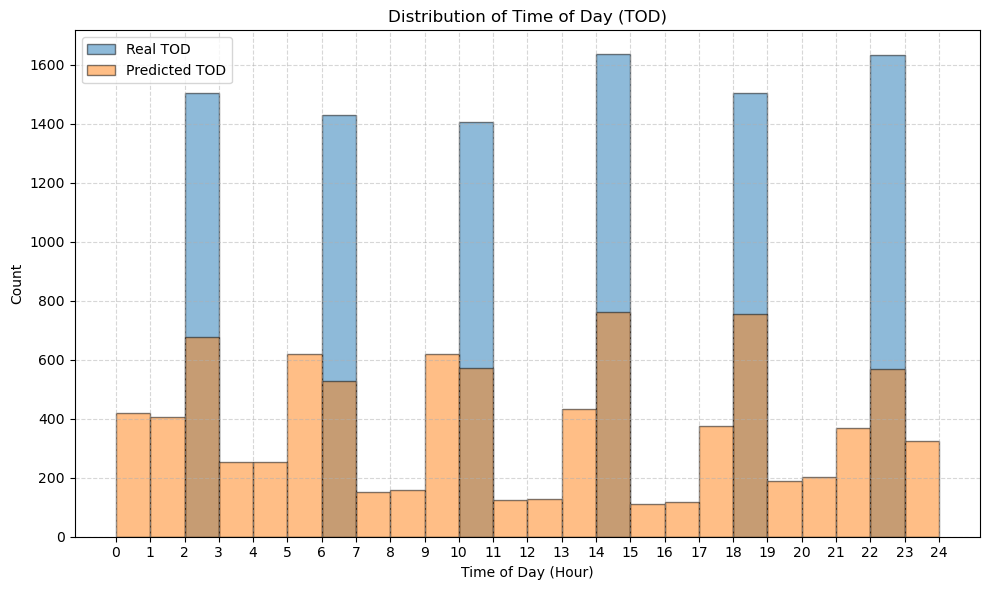

In [200]:
plt.figure(figsize=(10, 6))
plt.hist(Microglia_adata_testing.obs['TOD'], bins=24, range=(0, 24), alpha=0.5, label='Real TOD', edgecolor='black')
plt.hist(Microglia_adata_testing.obs['Predict time'], bins=24, range=(0, 24), alpha=0.5, label='Predicted TOD', edgecolor='black')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Count')
plt.title('Distribution of Time of Day (TOD)')
plt.xticks(range(0, 25, 1))  
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

## Astrocyte

### Training & Validation

In [130]:
Astrocyte_adata

View of AnnData object with n_obs × n_vars = 24974 × 55416
    obs: 'cell_type', 'Age_Time', 'total_UMI', 'TOD'
    var: 'gene_id', 'gene_type', 'gene_name'

In [131]:
Astrocyte_adata.obs

,cell_type,Age_Time,total_UMI,TOD
47647,Astrocyte,Adult_18,10862.0,18.0
47648,Astrocyte,Adult_18,10883.0,18.0
47649,Astrocyte,Adult_18,10628.0,18.0
47650,Astrocyte,Adult_18,10939.0,18.0
47651,Astrocyte,Adult_18,10620.0,18.0
...,...,...,...,...
72616,Astrocyte,Aged_62,10506.0,14.0
72617,Astrocyte,Aged_62,11449.0,14.0
72618,Astrocyte,Aged_62,14312.0,14.0
72619,Astrocyte,Aged_62,10353.0,14.0


In [132]:
sampled_indices = Astrocyte_adata.obs.sample(frac=0.6, random_state=42).index
sampled_indices

Index(['64914', '66620', '50187', '60790', '56041', '62052', '61898', '53054',
       '50545', '71059',
       ...
       '58313', '54427', '59770', '54265', '50274', '51420', '58206', '49886',
       '51310', '67543'],
      dtype='object', length=14984)

In [133]:
Astrocyte_adata_training = Astrocyte_adata[sampled_indices, :].copy()

In [134]:
Astrocyte_adata_training

AnnData object with n_obs × n_vars = 14984 × 55416
    obs: 'cell_type', 'Age_Time', 'total_UMI', 'TOD'
    var: 'gene_id', 'gene_type', 'gene_name'

In [135]:
Astrocyte_adata_training.obs

,cell_type,Age_Time,total_UMI,TOD
64914,Astrocyte,Adult_38,10284.0,14.0
66620,Astrocyte,Adult_18,10562.0,18.0
50187,Astrocyte,Adult_22,10400.0,22.0
60790,Astrocyte,Adult_42,11090.0,18.0
56041,Astrocyte,Adult_54,11330.0,6.0
...,...,...,...,...
51420,Astrocyte,Adult_18,10424.0,18.0
58206,Astrocyte,Adult_30,11037.0,6.0
49886,Astrocyte,Adult_22,13505.0,22.0
51310,Astrocyte,Adult_18,10060.0,18.0


In [136]:
expr_matrix = Astrocyte_adata_training.X.toarray()

In [137]:
expr_matrix

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 2., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.]], shape=(14984, 55416), dtype=float32)

In [138]:
N_cells, N_genes = expr_matrix.shape

In [139]:
times = Astrocyte_adata_training.obs['TOD']

In [140]:
times

64914    14.0
66620    18.0
50187    22.0
60790    18.0
56041     6.0
         ... 
51420    18.0
58206     6.0
49886    22.0
51310    18.0
67543    22.0
Name: TOD, Length: 14984, dtype: float64

In [141]:
dataset = CircadianDataset(expr_matrix, times)

In [142]:
n_train = int(0.8 * len(dataset))
n_val = len(dataset) - n_train
train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [144]:
# Model Instantiation: The input dimension is the number of genes
model = CircadianNet(input_dim=N_genes).to(device)
# Loss Function: MSE is most commonly used in the sin/cos space
criterion = nn.MSELoss()
# Optimizer: Adam Adaptive Learning Rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [145]:
train_loss = 1
val_mae = 10
epoch = 1
Training_cycle = 1

while (not ((train_loss < 0.16) and (val_mae < 2.5))):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_mae = evaluate(model, val_loader, device)
    print(f"Training cycle {Training_cycle:02d}:   Epoch {epoch:02d}  Train Loss: {train_loss:.4f}  Val Circular MAE: {val_mae:.4f} hours")
    epoch = epoch + 1
    if epoch > 50: 
        print(f'\n\nTraining # {Training_cycle} failed! Restart the # {Training_cycle+1} training cycle ... \n')
        n_train = int(0.8 * len(dataset))
        n_val = len(dataset) - n_train
        train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])
        train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=32)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Model Instantiation: The input dimension is the number of genes
        model = CircadianNet(input_dim=N_genes).to(device)
        # Loss Function: MSE is most commonly used in the sin/cos space
        criterion = nn.MSELoss()
        # Optimizer: Adam Adaptive Learning Rate
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        epoch = 1
        Training_cycle = Training_cycle + 1

Training cycle 01:   Epoch 01  Train Loss: 0.5787  Val Circular MAE: 2.6023 hours
Training cycle 01:   Epoch 02  Train Loss: 0.2675  Val Circular MAE: 1.7184 hours
Training cycle 01:   Epoch 03  Train Loss: 0.2177  Val Circular MAE: 1.6892 hours
Training cycle 01:   Epoch 04  Train Loss: 0.1959  Val Circular MAE: 2.5037 hours
Training cycle 01:   Epoch 05  Train Loss: 0.1804  Val Circular MAE: 1.5315 hours
Training cycle 01:   Epoch 06  Train Loss: 0.1630  Val Circular MAE: 1.5613 hours
Training cycle 01:   Epoch 07  Train Loss: 0.1620  Val Circular MAE: 1.5097 hours
Training cycle 01:   Epoch 08  Train Loss: 0.1565  Val Circular MAE: 1.4335 hours


In [160]:
torch.save(model.state_dict(), './Model_param/ANN/Astrocyte.pth')

### Testing

In [161]:
remaining_indices = Astrocyte_adata.obs.index.difference(sampled_indices)

In [162]:
remaining_indices

Index(['47648', '47649', '47656', '47657', '47658', '47659', '47660', '47663',
       '47665', '47668',
       ...
       '72601', '72602', '72603', '72608', '72609', '72610', '72612', '72617',
       '72619', '72620'],
      dtype='object', length=9990)

In [163]:
Astrocyte_adata_testing = Astrocyte_adata[remaining_indices, :].copy()

In [164]:
Astrocyte_adata_testing.obs

,cell_type,Age_Time,total_UMI,TOD
47648,Astrocyte,Adult_18,10883.0,18.0
47649,Astrocyte,Adult_18,10628.0,18.0
47656,Astrocyte,Adult_18,10434.0,18.0
47657,Astrocyte,Adult_18,10200.0,18.0
47658,Astrocyte,Adult_18,11181.0,18.0
...,...,...,...,...
72610,Astrocyte,Aged_62,21317.0,14.0
72612,Astrocyte,Aged_62,10149.0,14.0
72617,Astrocyte,Aged_62,11449.0,14.0
72619,Astrocyte,Aged_62,10353.0,14.0


In [165]:
expr_matrix = Astrocyte_adata_testing.X.toarray()

In [166]:
expr_matrix

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 2., ..., 0., 0., 2.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 2.]], shape=(9990, 55416), dtype=float32)

In [167]:
N_cells, N_genes = expr_matrix.shape

In [168]:
test_model = CircadianNet(input_dim=N_genes)
test_model.load_state_dict(torch.load("./Model_param/ANN/Astrocyte.pth"))
test_model.eval()

/tmp/ipykernel_151467/3074869385.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("./Model_param/ANN/Astrocyte.pth"))


CircadianNet(
  (model): Sequential(
    (0): Linear(in_features=55416, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [169]:
input_tensor = torch.from_numpy(expr_matrix)

In [170]:
# Infer to obtain the predicted value of sin/cos
with torch.no_grad():
    pred_vec = test_model(input_tensor)  # shape: (n_cells, 2)

# Convert sin/cos to time (hours)
pred_angles = torch.atan2(pred_vec[:, 0], pred_vec[:, 1])  # atan2(sin, cos)
pred_hours = (pred_angles % (2 * np.pi)) * (24 / (2 * np.pi))

In [171]:
pred_hours

tensor([17.6908, 16.4711, 17.8818,  ..., 13.6956, 13.9824, 13.9635])

In [172]:
Astrocyte_adata_testing.obs['Predict time'] = pred_hours

In [173]:
Astrocyte_adata_testing.obs

,cell_type,Age_Time,total_UMI,TOD,Predict time
47648,Astrocyte,Adult_18,10883.0,18.0,17.690804
47649,Astrocyte,Adult_18,10628.0,18.0,16.471062
47656,Astrocyte,Adult_18,10434.0,18.0,17.881832
47657,Astrocyte,Adult_18,10200.0,18.0,17.843874
47658,Astrocyte,Adult_18,11181.0,18.0,21.769461
...,...,...,...,...,...
72610,Astrocyte,Aged_62,21317.0,14.0,15.015277
72612,Astrocyte,Aged_62,10149.0,14.0,13.927961
72617,Astrocyte,Aged_62,11449.0,14.0,13.695635
72619,Astrocyte,Aged_62,10353.0,14.0,13.982417


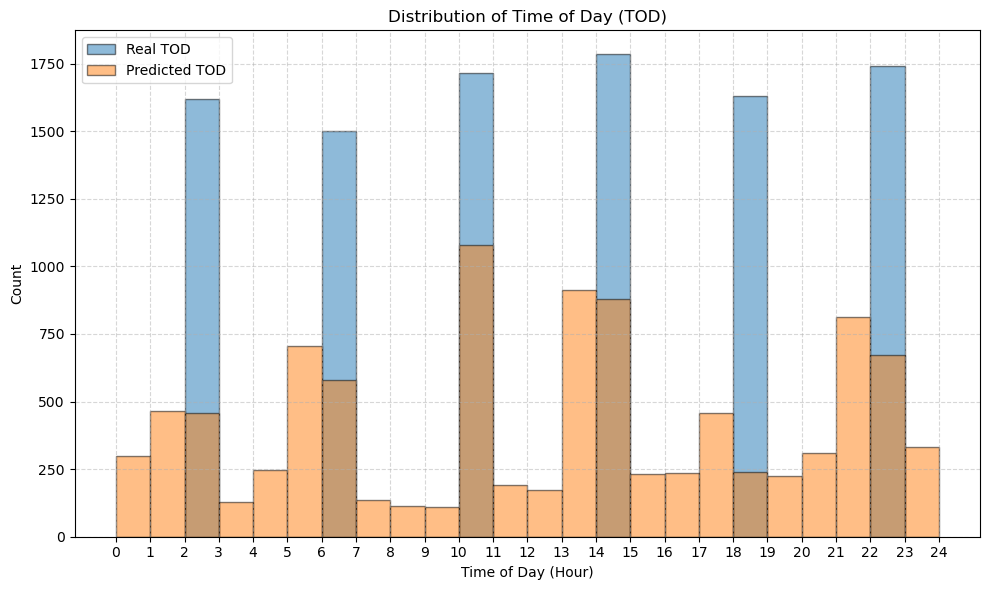

In [174]:
plt.figure(figsize=(10, 6))
plt.hist(Astrocyte_adata_testing.obs['TOD'], bins=24, range=(0, 24), alpha=0.5, label='Real TOD', edgecolor='black')
plt.hist(Astrocyte_adata_testing.obs['Predict time'], bins=24, range=(0, 24), alpha=0.5, label='Predicted TOD', edgecolor='black')
plt.xlabel('Time of Day (Hour)')
plt.ylabel('Count')
plt.title('Distribution of Time of Day (TOD)')
plt.xticks(range(0, 25, 1))  
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()